In [1]:
# Physics modules
from metric import metric
from hybrid_eos import hybrid_eos

# Numpy and matplotlib
import numpy as np 
import matplotlib.pyplot as plt 

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init 
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
class c2p_NN(nn.Module):
    """
    This class defines a neural network model for the conservative-to-primitive variable transformation.
    The network consists of several fully connected layers with ReLU activation functions and batch normalization.
    The input to the network is a tensor of conservative variables, and the output is a tensor of primitive variables.
    """
    def __init__(self, hidden_layers=3, neurons=50):
        super(c2p_NN, self).__init__()
        self.activation = nn.Tanh 
        input_dim = 3 
        output_dim = 1 
        layers = []
        layers.append(nn.BatchNorm1d(input_dim))
        layers.append(nn.Linear(input_dim, neurons))  # Input layer
        layers.append(self.activation())  # Activation
        for _ in range(hidden_layers):
            layers.append(nn.Linear(neurons, neurons))  # Hidden layers
            layers.append(nn.BatchNorm1d(neurons)) # Normalization
            layers.append(self.activation())  # Activation
            
        layers.append(nn.Linear(neurons, output_dim))  # Output layer
        # Last relu because z >= 0 
        layers.append(nn.ReLU()                     )  # Activation
        self.network = nn.Sequential(*layers)
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """ Initialize weights using Kaiming initialization """
        if isinstance(module, nn.Linear):
            #init.kaiming_normal_(module.weight, nonlinearity="relu")
            init.xavier_normal_(module.weight)
            init.zeros_(module.bias)
    
    def forward(self, x):
        return self.network(x)


In [4]:
class C2P_Dataset(TensorDataset):
    
    def __init__(self,C,Z):
        
        self.C = C 
        self.Z = Z 
        
    def __len__(self):
        return self.C.shape[0]
    
    def __getitem__(self,idx):
        return self.C[idx,:], self.Z[idx]


In [5]:
# Minkowski metric 
eta = metric(
torch.eye(3,device=device), torch.zeros(3,device=device), torch.ones(1,device=device)
)
# Gamma = 2 EOS with ideal gas thermal contrib 
eos = hybrid_eos(100,2,1.8)

In [6]:
def setup_initial_state_random(metric,eos,N,device,lrhomin=-12,lrhomax=-2.8,ltempmin=-1,ltempmax=2.3,Wmin=1,Wmax=2):
    # Get W, rho and T 
    W = Wmin + (Wmax-Wmin) * torch.rand(N,device=device)
    rho = 10**( lrhomin + (lrhomax-lrhomin) * torch.rand(N,device=device) )
    T = 10**( ltempmin + (ltempmax-ltempmin) * torch.rand(N,device=device) )
    # Call EOS to get press and eps 
    press,eps = eos.press_eps__temp_rho(T,rho)
    # Compute z 
    Z = torch.sqrt(1 - 1/W**2) * W 
    
    # Compute conserved vars 
    sqrtg = metric.sqrtg 
    u0 = W / sqrtg 
    dens = sqrtg * W * rho 
    
    rho0_h = rho * ( 1 + eps ) + press 
    g4uptt = - 1/metric.alp**2 
    Tuptt = rho0_h * u0**2 + press * g4uptt 
    tau = metric.alp**2 * sqrtg * Tuptt - dens 
    
    S = torch.sqrt((W**2-1)) * rho0_h * W
    # Assemble output 
    C = torch.cat((dens.view(-1,1)/metric.sqrtg,tau.view(-1,1)/dens.view(-1,1),S.view(-1,1)/dens.view(-1,1)),dim=1)
    return C, Z.view(-1,1)

def setup_initial_state_meshgrid(metric,eos,N,device,lrhomin=-12,lrhomax=-2.8,ltempmin=-1,ltempmax=2.3,Wmin=1,Wmax=2):
    # Get W, rho and T 
    W = torch.linspace(Wmin,Wmax,N,device=device)
    rho = 10**( torch.linspace(lrhomin,lrhomax,N,device=device) )
    T = 10**( torch.linspace(ltempmin,ltempmax,N,device=device) )
    W, rho, T = torch.meshgrid(W,rho,T, indexing='ij')
    
    W = W.flatten() 
    rho = rho.flatten()
    T = T.flatten() 
    
    # Call EOS to get press and eps 
    press,eps = eos.press_eps__temp_rho(T,rho)
    # Compute z 
    Z = torch.sqrt(1 - 1/W**2) * W 
    
    # Compute conserved vars 
    sqrtg = metric.sqrtg 
    u0 = W / sqrtg 
    dens = sqrtg * W * rho 
    
    rho0_h = rho * ( 1 + eps ) + press 
    g4uptt = - 1/metric.alp**2 
    Tuptt = rho0_h * u0**2 + press * g4uptt 
    tau = metric.alp**2 * sqrtg * Tuptt - dens 
    
    S = torch.sqrt((W**2-1)) * rho0_h * W
    # Assemble output 
    C = torch.cat((dens.view(-1,1)/metric.sqrtg,tau.view(-1,1)/dens.view(-1,1),S.view(-1,1)/dens.view(-1,1)),dim=1)
    return C, Z.view(-1,1)
    
def sanity_check(Z,C, metric, eos):
    t,q,r = torch.split(C,[1,1,1], dim=1)
    htilde = h__z(Z,C,eos)
    
    return torch.mean((Z - r/htilde)**2)

def W__z(z):
    return torch.sqrt(1 + z**2)

def rho__z(z,C):
    return C[:,0].view(-1,1) / W__z(z)

def eps__z(z,C):
    q = C[:,1].view(-1,1)
    r = C[:,2].view(-1,1)
    W = W__z(z)
    return W * q - z * r + z**2/(1+W)

def a__z(z,C,eos):
    eps = eps__z(z,C)
    rho = rho__z(z,C)
    press = eos.press__eps_rho(eps,rho)
    return press/(rho*(1+eps))

def h__z(z,C,eos):
    eps = eps__z(z,C)
    a = a__z(z,C,eos)
    return (1 + eps)*(1+a)

In [7]:
C, Z = setup_initial_state_meshgrid(eta,eos,25,device)
err = sanity_check(Z,C,eta,eos)

C_test_min, _ = torch.min(C,dim=0)
C_test_max, _ = torch.max(C,dim=0)
Z_test_min, _ = torch.min(Z,dim=0)
Z_test_max, _ = torch.max(Z,dim=0)

C = (C - C_test_min) / (C_test_max - C_test_min)
Z = (Z - Z_test_min) / (Z_test_max - Z_test_min)

print(err)

tensor(1.9637e-13, device='cuda:0')


In [ ]:
def compute_loss(model, C, eos, metric, Z_min = -1, Z_max = -1, C_min = -1, C_max = -1):
    '''
    Eq (C3) of https://arxiv.org/pdf/1306.4953.pdf
    '''
    Z_pred = model(C)
    Z_pred = Z_pred * (Z_max - Z_min) + Z_min
    C = C * (C_max - C_min) + C_min
    htilde = h__z(Z_pred,C,eos)
    return F.mse_loss(Z_pred,C[:,2].view(-1,1)/htilde)

In [9]:
def train_c2p_model(model,optimizer,scheduler,dataloader,validation_dataset, num_epochs,eos,metric,training_loss,validation_loss, Z_min = -1, Z_max = -1, C_min = -1, C_max = -1):
    for epoch in range(num_epochs):
        epoch_loss = 0 
        
        for C_data, _ in dataloader:
            optimizer.zero_grad()
            
            loss = compute_loss(model,C_data,eos,metric,Z_min = Z_test_min, Z_max = Z_test_max, C_min = C_test_min, C_max = C_test_max)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() 
        
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_loss)
        else:
            scheduler.step()
        # Compute test loss 
        C_test, Z_test = validation_dataset[:]
        test_loss = compute_loss(model,C_test,eos,metric,Z_min = Z_test_min, Z_max = Z_test_max, C_min = C_test_min, C_max = C_test_max)
        training_loss.append(epoch_loss/len(dataloader))
        validation_loss.append(test_loss.item())
        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss/len(dataloader):.6f}, Test loss: {test_loss.item():.6f}")

In [ ]:
neurons = 50 
layers  = 4

n_epochs = 120

C_test, Z_test = setup_initial_state_random(eta,eos,1000,device)


training_loss = []
validation_loss = []

batch_size = 32  # You can experiment with this
dataset = C2P_Dataset(C, Z)
print(dataset)

# Define split sizes
train_size = int(0.8 * len(dataset))  # 80% training
val_size = len(dataset) - train_size  # 20% validation

# Split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


net = c2p_NN(hidden_layers=layers,neurons=neurons).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
#torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)
#torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500)

train_c2p_model(net,optimizer,scheduler,train_dataloader,val_dataset,n_epochs,eos,eta,training_loss,validation_loss, Z_min = Z_test_min, Z_max = Z_test_max, C_min = C_test_min, C_max = C_test_max)

# Do one more step with LBFGS
optimizer = torch.optim.LBFGS(net.parameters(), lr=0.1, max_iter=50)

def closure():
    optimizer.zero_grad()
    loss = compute_loss(net, C, eos, eta)
    loss.backward()
    return loss

optimizer.step(closure)

loss_value = closure()  # Compute the loss
print(f"Final loss: {loss_value.item()}")  

torch.save(net.state_dict(), f"model_L{layers}N{neurons}.pt")

/mnt/rafast/miler/python-env/pytorch/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Epoch 0, Loss: nan, Test loss: nan
Epoch 10, Loss: nan, Test loss: nan
Epoch 20, Loss: nan, Test loss: nan
Epoch 30, Loss: nan, Test loss: nan


In [ ]:
Z_pred = net(C_test)
print("Sanity check: ",sanity_check(Z_test,C_test,eta,eos))
print("Network error: ",compute_loss(net,C_test,eos,eta) )

Sanity check:  tensor(1.8908e-13, device='cuda:0')
Network error:  tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


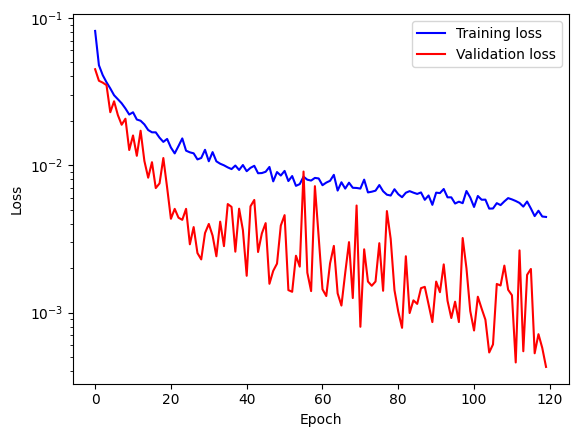

In [ ]:
fig,ax = plt.subplots()
ax.semilogy(training_loss,label='Training loss', color="blue")
ax.semilogy(validation_loss,label='Validation loss', color="red")


ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

In [ ]:
x = torch.linspace(1,2,100)
y = torch.linspace(1,2,100)
z = torch.linspace(1,2,100)
X,Y,Z = torch.meshgrid(x,y,z)

/mnt/rafast/miler/python-env/pytorch/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
